# Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
from torchvision import transforms
from torch import nn, optim
from torch.autograd import Variable
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from skimage import color, exposure
from skimage.color import rgb2lab, lab2rgb
from torchview import draw_graph

## Data handling

We used the CIFAR-10 dataset to train both our models. The images in this dataset have the dimensions 32x32 and is encoded in the RGB colorspace. While these dimensions do not translate
to a model that could be used to colorize real-world images, the small dimensions allowed us to deal with memory and computation constraints. We did not focus on a specific category and instead trained our models on all the 50,000 images in the training set to build a more generalized model.

In [2]:
tensor_transform = transforms.ToTensor()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=tensor_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=tensor_transform)

Files already downloaded and verified


## Preprocessing function
The 32x32x3 images in the RGB colorspace were converted into the CIE Lab colorspace. The L (luminance) channel is sufficient to represent the grayscale image, and all the color information is encoded into the a and b channels. Consequently, a dataset with input dimensions of 32x32x1 and output dimensions of 32x32x2 was generated instead of dealing with 32x32x3 images as input and output. To obtain the final image from the output, the L channel is concatenated with the a and b channels and subsequently converted back to the RGB colorspace. Additionally, the resulting image is transformed to the range of [0, 1] for normalization.


In [4]:
def preprocess(dataset):
    # Transform the images to CieLAB color space by the use of OpenCV library.
    rgb_images = []
    numpy_lab_images = []
    
    for image,labels in dataset:
        rgb_images.append(image)
    
    for rgb_image in rgb_images:
        numpy_rgb_image = np.transpose(rgb_image.numpy(), (1, 2, 0))
        numpy_lab_image = cv2.cvtColor(numpy_rgb_image, cv2.COLOR_RGB2LAB)
        numpy_lab_images.append(numpy_lab_image)
    
    # Transform the numpy lab images to images of range [0, 1] and further
    # convert them to tensors.
    lab_images = []
    for numpy_lab_image in numpy_lab_images:
        numpy_lab_image[:, :, 0] *= 255 / 100
        numpy_lab_image[:, :, 1] += 128
        numpy_lab_image[:, :, 2] += 128
        numpy_lab_image /= 255
        torch_lab_image = torch.from_numpy(np.transpose(numpy_lab_image, (2, 0, 1)))
        lab_images.append(torch_lab_image)
        
    return lab_images
    

In [5]:
trainset_lab = preprocess(trainset)
testset_lab = preprocess(testset)

## Dataset and Dataloader objects

In [7]:
class CieLABDataset(torch.utils.data.Dataset):
    """CieLab dataset."""

    def __init__(self, lab_images):
        self.lab_images = lab_images

    def __len__(self):
        return len(self.lab_images)

    def __getitem__(self, index):
        img = self.lab_images[index]
        return img


In [8]:
cie_lab_dataset_test = CieLABDataset(testset_lab)
cielab_dataset = CieLABDataset(trainset_lab)
cielab_loader = torch.utils.data.DataLoader(cielab_dataset, batch_size=128,
                  shuffle=True, num_workers=2)
cielab_loader_test = torch.utils.data.DataLoader(cie_lab_dataset_test, batch_size=128,
                  shuffle=True, num_workers=2)

## Creating Discriminator and Generator models

In [9]:
class UNet(nn.Module):
    
    def unet_conv(self, ch_in, ch_out, is_leaky):
        """
        Construct a convolutional unit comprising of two conv layers
        followed by a batch normalisation layer and ReLU/Leaky ReLU.
        """
        if is_leaky:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU(),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU()
            )
        
    def up(self, ch_in, ch_out):
        """
        Applies a 2D bilinear upsampling to the input image which scales
        the image 2x times, followed by a convolution with a 1x1 kernel. 
        """
        return nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, 3, 2, 1, 1), 
            nn.ReLU()
        )
    
    def __init__(self, is_leaky):
        """
        In the constructer, all the convolutional, upsampling and max pooling 
        units are instantiated and assigned as member variables. 
        """
        super(UNet, self).__init__()
        
        # First encoding layer
        self.conv1 = self.unet_conv(1, 64, is_leaky)
        # Second encoding layer
        self.conv2 = self.unet_conv(64, 128, is_leaky)
        # Third encoding layer
        self.conv3 = self.unet_conv(128, 256, is_leaky)
        # Fourth encoding layer
        self.conv4 = self.unet_conv(256, 512, is_leaky)
        # Fifth encoding layer
        self.conv5 = self.unet_conv(512, 1024, is_leaky)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        # First Upsampling layer
        self.up1 = self.up(1024, 512)
        # Second Upsampling layer
        self.up2 = self.up(512, 256)
        # Third Upsampling layer
        self.up3 = self.up(256, 128)
        # Fourth Upsampling layer
        self.up4 = self.up(128, 64)
        
        # First decoding layer
        self.conv6 = self.unet_conv(1024, 512, False)
        # Second decoding layer
        self.conv7 = self.unet_conv(512, 256, False)
        # Third decoding layer
        self.conv8 = self.unet_conv(256, 128, False)
        # Fourth decoding layer
        self.conv9 = self.unet_conv(128, 64, False)
        
        # Last layer
        self.conv10 = nn.Conv2d(64, 2, 1)

    def forward(self, x):
        """ 
        An input tensor of a black and white image is accepted and
        passed through the U-Net model. A colored image in CieLAB color
        space is returned as the result. 
        """
        # Encoding path
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x5 = self.conv5(self.pool(x4))
        
        # Decoding path
        x = self.conv6(torch.cat((x4, self.up1(x5)), 1))
        x = self.conv7(torch.cat((x3, self.up2(x)), 1))
        x = self.conv8(torch.cat((x2, self.up3(x)), 1))
        x = self.conv9(torch.cat((x1, self.up4(x)), 1))
        x = self.conv10(x)
        m = nn.Tanh()
        x = m(x)
        
        return x

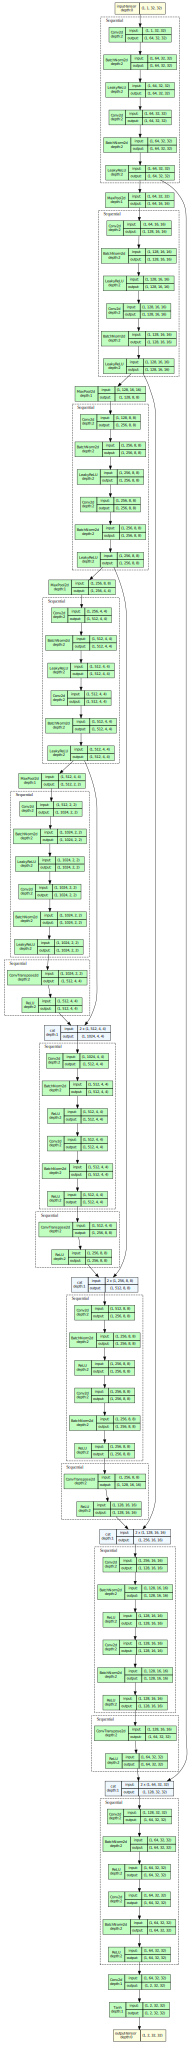

In [41]:
model = UNet(True)

# Create a dummy input tensor
input_tensor = torch.randn(1, 1, 32, 32)
# Forward pass through the model
output = model(input_tensor)
# Visualize the model graph
model_graph = draw_graph(model, input_size=(1, 1, 32, 32), expand_nested=True)
model_graph.visual_graph

In [10]:
class DNet(nn.Module):
    
    def unet_conv(self, ch_in, ch_out):
        """
        Construct a convolutional unit comprising of two conv layers
        followed by a batch normalisation layer and Leaky ReLU.
        """
        return nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ch_out, ch_out, 3, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2)
        )
    
    def __init__(self):
        super(DNet, self).__init__()
        """
        In the constructer, all the convolutional and max pooling units 
        are instantiated and assigned as member variables. 
        """
        # First layer
        self.conv1 = self.unet_conv(3, 64)
        # Second layer
        self.conv2 = self.unet_conv(64, 128)
        # Third layer
        self.conv3 = self.unet_conv(128, 256)
        # Fourth layer
        self.conv4 = self.unet_conv(256, 512)
        # Fifth layer
        self.conv5 = self.unet_conv(512, 1024)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        # Last layer
        self.conv6 = nn.Linear(2 * 2 * 1024, 1)

    def forward(self, x):
        """ 
        An input tensor of a colored image from either the generator or source
        is accepted and passed through the model. The probability of the image
        belonging to the source domain is returned as the result. 
        """
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x5 = self.conv5(self.pool(x4))
        
        x6 = x5.view(-1, 2 * 2 * 1024)
        m = nn.Sigmoid()
        x = m(self.conv6(x6))
        
        return x

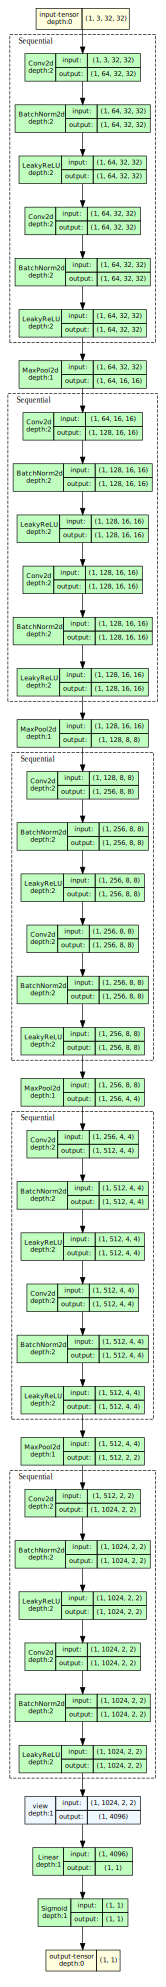

In [42]:
model = DNet()

input_tensor = torch.randn(1, 3, 32, 32)
# Forward pass through the model
output = model(input_tensor)
# Visualize the model graph
model_graph = draw_graph(model, input_size=(1, 3, 32, 32), expand_nested=True)
model_graph.visual_graph.name = 'Discriminator Model'
model_graph.visual_graph

In [11]:
# Initialise the generator and discriminator with the UNet and
# DNet architectures respectively.
generator = UNet(True)
discriminator = DNet()

In [12]:
# Utilize GPU for performing all the calculations performed in the
# forward and backward passes. Thus allocate all the generator and
# discriminator variables on the default GPU device.
generator.cuda()
discriminator.cuda()

DNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256

In [13]:
# Create ADAM optimizer for the generator as well the discriminator.
# Create loss criterion for calculating the L1 and adversarial loss.
d_optimizer = optim.Adam(discriminator.parameters(), betas=(0.5, 0.999), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), betas=(0.5, 0.999), lr=0.0002)

d_criterion = nn.BCELoss()
g_criterion_1 = nn.BCELoss()
g_criterion_2 = nn.L1Loss()


In [13]:
generator_losses = []  # List to store generator losses for each epoch
discriminator_losses = []  # List to store discriminator losses for each epoch
def train_():
    """
    Train the dataset for several epochs.
    """
    g_lambda = 100
    smooth = 0.1



    # loop over the dataset multiple times.
    for epoch in range(277):
        # the generator and discriminator losses are summed for the entire epoch.
        d_running_loss = 0.0
        g_running_loss = 0.0
        for i, data in enumerate(cielab_loader):
            lab_images = data
            # split the lab color space images into luminescence and chrominance channels.
            l_images = lab_images[:, 0, :, :]
            c_images = lab_images[:, 1:, :, :]
            # shift the source and target images into the range [-0.5, 0.5].
            mean = torch.Tensor([0.5])
            l_images = l_images - mean.expand_as(l_images)
            l_images = 2 * l_images

            c_images = c_images - mean.expand_as(c_images)
            c_images = 2 * c_images
            # allocate the images on the default gpu device.
            batch_size = l_images.shape[0]
            l_images = l_images.unsqueeze(1)
            l_images = Variable(l_images.cuda())
            c_images = Variable(c_images.cuda())
            # fake images are generated by passing them through the generator.
            fake_images = generator(l_images)
            
            

            # Train the discriminator. The loss would be the sum of the losses over
            # the source and fake images, with greyscale images as the condition.
            d_optimizer.zero_grad()
            d_loss = 0
            logits = discriminator(torch.cat([l_images, c_images], 1))
            d_real_loss = d_criterion(logits, (1 - smooth) * torch.ones(batch_size, 1).cuda())

            logits = discriminator(torch.cat([l_images, fake_images], 1))
            d_fake_loss = d_criterion(logits, torch.zeros(batch_size, 1).cuda())

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward(retain_graph=True)

            d_optimizer.step()

            # Train the generator. The loss would be the sum of the adversarial loss
            # due to the GAN and L1 distance loss between the fake and target images.
            g_optimizer.zero_grad()
            g_loss = 0
            fake_logits = discriminator(torch.cat([l_images, fake_images], 1))
            g_fake_loss = g_criterion_1(fake_logits, torch.ones(batch_size, 1).cuda())

            g_image_distance_loss = g_lambda * g_criterion_2(fake_images, c_images)

            g_loss = g_fake_loss + g_image_distance_loss
            g_loss.backward()
            g_optimizer.step()

            # print statistics on pre-defined intervals.
            d_running_loss += d_loss.item()
            g_running_loss += g_loss.item()
            
            
            
            if i % 10 == 0:
                print('[%d, %5d] d_loss: %.5f g_loss: %.5f' %
                      (epoch + 1, i + 1, d_running_loss / 10, g_running_loss / 10))
                d_running_loss = 0.0
                g_running_loss = 0.0
                
        # Append the epoch losses to the corresponding lists
        discriminator_losses.append(d_loss.item())
        generator_losses.append(g_loss.item())
        # save the generator and discriminator state after each epoch.
        torch.save(generator.state_dict(), '/kaggle/working/generator.pth')
        torch.save(discriminator.state_dict(), '/kaggle/working/discriminator.pth')


    print('Finished Training')


## Training the model on %1 of the images

The model was trained on a subset of 1% of the available images for a duration of 250+ epochs. The purpose of this training process was to thoroughly explore the model's ability to learn and generalize from a limited amount of training data. By training over multiple epochs, the model had the opportunity to gradually refine its weights and adjust its internal parameters to optimize its performance on the given dataset.
In this context, training on a limited dataset for an extended period increases the risk of the model memorizing specific patterns and idiosyncrasies of the training samples, rather than learning generalizable features.
Further cells you are going to see model overfits to the subset of data

In [14]:
train_()

[1,     1] d_loss: 0.14332 g_loss: 2.46923
[2,     1] d_loss: 3.00641 g_loss: 2.40267
[3,     1] d_loss: 1.21938 g_loss: 2.21936
[4,     1] d_loss: 0.19745 g_loss: 1.76901
[5,     1] d_loss: 0.18333 g_loss: 1.67562
[6,     1] d_loss: 0.16822 g_loss: 1.53881
[7,     1] d_loss: 0.13788 g_loss: 1.46443
[8,     1] d_loss: 0.13547 g_loss: 1.44561
[9,     1] d_loss: 0.13684 g_loss: 1.34795
[10,     1] d_loss: 0.13639 g_loss: 1.31016
[11,     1] d_loss: 0.13547 g_loss: 1.23536
[12,     1] d_loss: 0.13345 g_loss: 1.16659
[13,     1] d_loss: 0.13293 g_loss: 1.12993
[14,     1] d_loss: 0.13125 g_loss: 1.11110
[15,     1] d_loss: 0.13180 g_loss: 1.04306
[16,     1] d_loss: 0.13342 g_loss: 1.07155
[17,     1] d_loss: 0.13618 g_loss: 1.02210
[18,     1] d_loss: 0.13036 g_loss: 1.07133
[19,     1] d_loss: 0.12737 g_loss: 0.96970
[20,     1] d_loss: 0.12409 g_loss: 1.03491
[21,     1] d_loss: 0.13706 g_loss: 0.92601
[22,     1] d_loss: 0.13560 g_loss: 1.05343
[23,     1] d_loss: 0.12686 g_loss: 0.925

In [14]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    #L = (L + 1.) * 50.
    L = (L ) * 100.
    ab = (ab) * 127.5
    
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().detach().numpy()
    #Lab = torch.cat([L, ab], dim=1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = color.lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [15]:
def denormer(t):
    t = t * 255
    t = t.detach().cpu().numpy().transpose(1, 2, 0)
    t = np.clip(t, 0, 255).astype(np.uint8)

    rgb_image = cv2.cvtColor(t, cv2.COLOR_LAB2RGB)
    return rgb_image

128


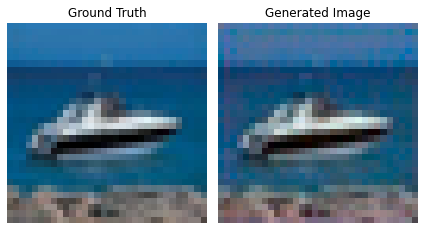

In [19]:
real_imgs = []
for data in cielab_loader:
    print(data.shape[0])
    lab_images = data
    l_images = lab_images[:, 0, :, :]
    ab_images = lab_images[:, 1:, :, :]
    
    # allocate the images on the default GPU device.
    l_images = l_images.unsqueeze(1)
    l_images = Variable(l_images.cuda())
    
    ab_images = ab_images.squeeze(1)  # Squeeze the extra dimension
    ab_images = Variable(ab_images.cuda())
    
    # Fake images are generated by passing them through the generator.
    fake_images = generator(l_images)
    
    fake_images = lab_to_rgb(l_images, fake_images)
    real_images = lab_to_rgb(l_images, ab_images)    



    rgb_image = denormer(data[0])
    
    for i in range(len(data)):
        real_imgs.append(denormer(data[i, :, :, :]))
        #print(i)

    
    # Plot the original ground truth image
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Plot the fake image generated by the generator
    plt.subplot(1, 2, 2)
    plt.imshow(fake_images[0])
    plt.title('Generated Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    break
    
    


In [16]:
def rgb_to_gray(rgb_image):
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    return gray_image

In [17]:
def visualizor(n):
    # Plot the original ground truth image
    plt.subplot(1, 3, 1)
    plt.imshow(real_imgs[n])
    plt.title('Ground Truth')
    plt.axis('off')

    # Plot the fake image generated by the generator
    plt.subplot(1, 3, 2)
    plt.imshow(rgb_to_gray(real_imgs[n]), cmap=plt.get_cmap('gray'))
    plt.title('Grayscale Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(fake_images[n])
    plt.title('Generated Image')
    plt.axis('off')


    plt.tight_layout()
    plt.show()
    

# Overfitted model (trained on %1 of trainset)

The training process has resulted in overfitting, where the model has become highly specialized to the limited training samples. As a consequence, the generator component of the model has learned to produce output images that precisely mimic the ground truth colors. The model has essentially memorized the specific color patterns of the training images, leading to the generation of exact color matches for the provided inputs. However, it is important to assess the model's generalization capabilities and evaluate its performance on unseen data to ensure its ability to produce accurate and diverse colorizations.

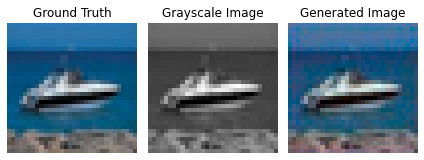

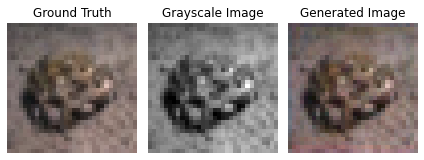

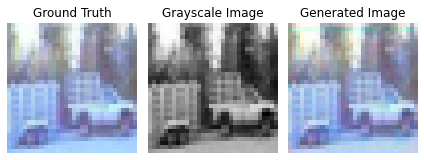

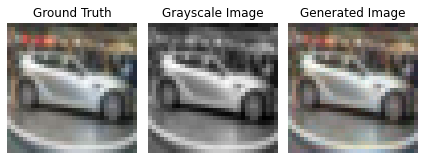

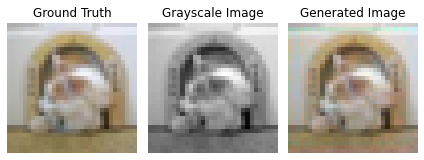

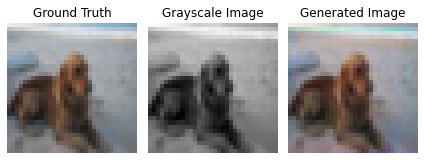

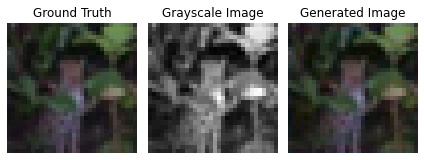

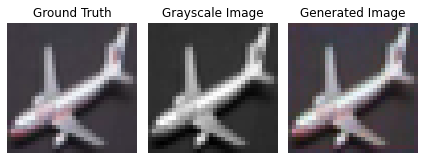

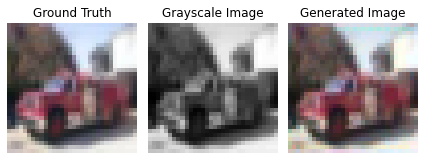

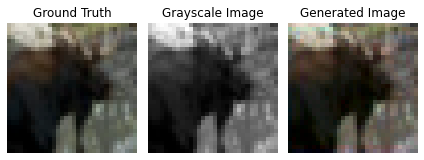

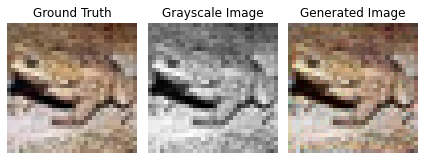

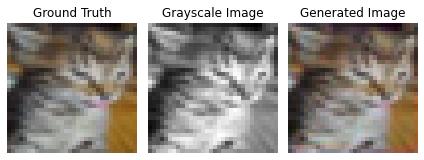

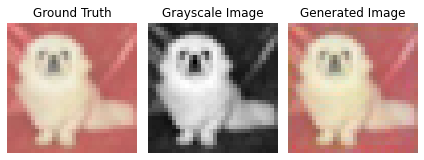

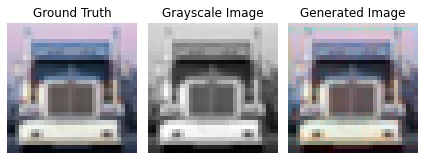

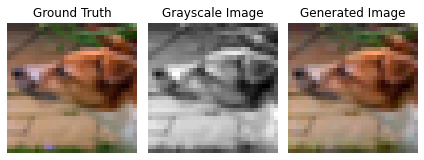

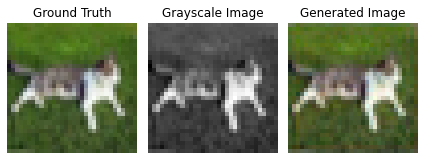

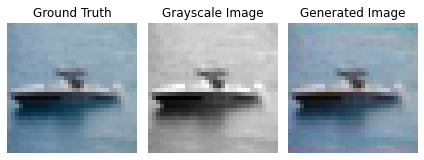

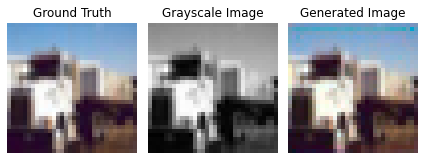

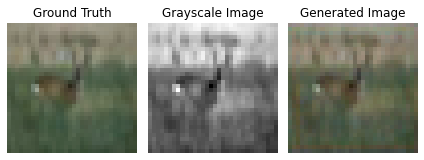

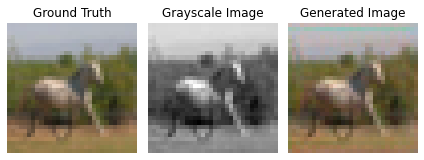

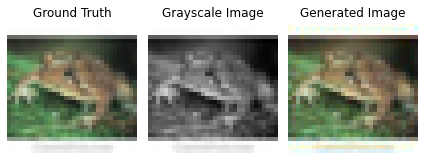

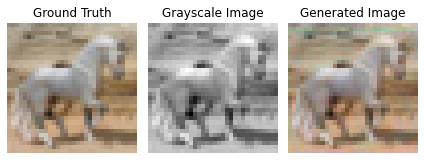

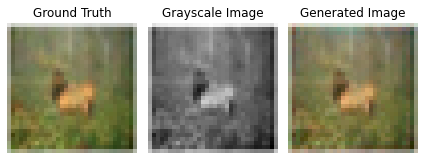

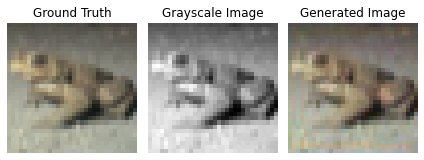

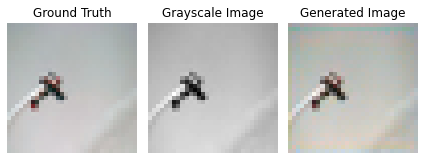

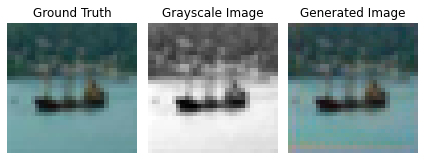

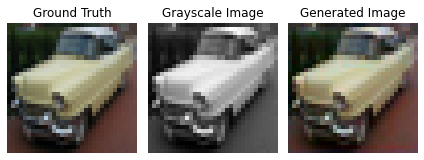

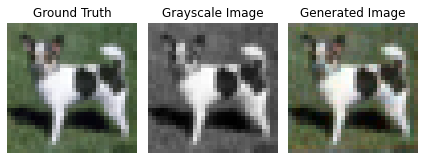

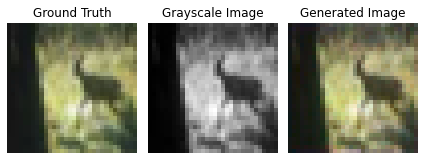

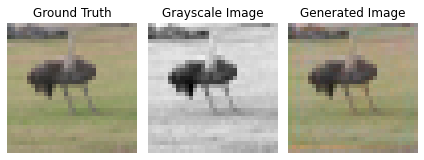

In [36]:
for i in range(30):
    visualizor(i)

# Loss function plot

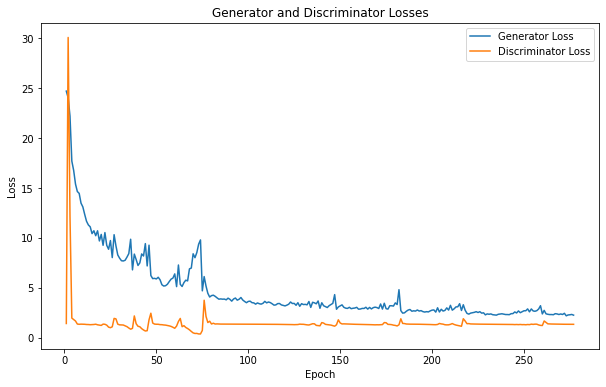

In [37]:
import matplotlib.pyplot as plt

def plot_losses(generator_losses, discriminator_losses):
    """
    Plot the generator and discriminator losses.
    """
    epochs = len(generator_losses)
    fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size
    ax.plot(range(1, epochs + 1), generator_losses, label='Generator Loss')
    ax.plot(range(1, epochs + 1), discriminator_losses, label='Discriminator Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Generator and Discriminator Losses')
    ax.legend()
    plt.show()

# Call the function to plot the losses
plot_losses(generator_losses, discriminator_losses)


# Results of overfitted model on Testset

128


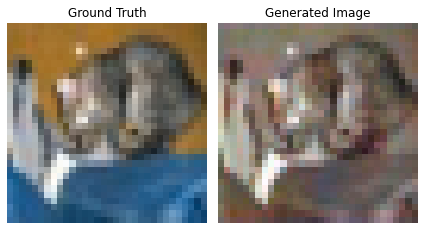

In [44]:
real_imgs = []
for data in cielab_loader:
    print(data.shape[0])
    lab_images = data
    l_images = lab_images[:, 0, :, :]
    ab_images = lab_images[:, 1:, :, :]
    
    # allocate the images on the default GPU device.
    l_images = l_images.unsqueeze(1)
    l_images = Variable(l_images.cuda())
    
    ab_images = ab_images.squeeze(1)  # Squeeze the extra dimension
    ab_images = Variable(ab_images.cuda())
    
    # Fake images are generated by passing them through the generator.
    fake_images = generator(l_images)
    
    fake_images = lab_to_rgb(l_images, fake_images)
    real_images = lab_to_rgb(l_images, ab_images)



    rgb_image = denormer(data[0])
    
    for i in range(len(data)):
        real_imgs.append(denormer(data[i, :, :, :]))
        #print(i)

    
    # Plot the original ground truth image
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Plot the fake image generated by the generator
    plt.subplot(1, 2, 2)
    plt.imshow(fake_images[0])
    plt.title('Generated Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    break
    
    


## Here is the results of the model performance on unseen testset
The model's performance on the unseen test set shows some promising results, but the generated images lack a high level of realism compared to the exact color matches achieved during training. Further improvements are needed to enhance the model's ability to generate diverse and realistic colorizations.

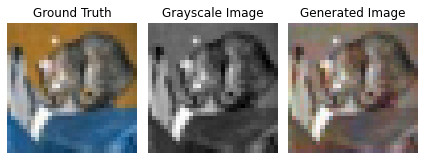

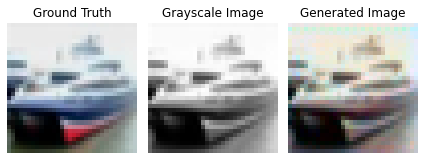

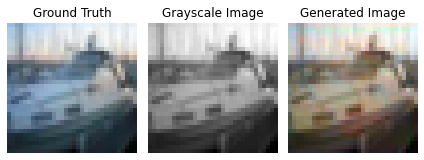

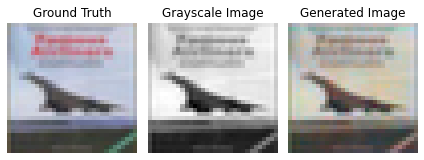

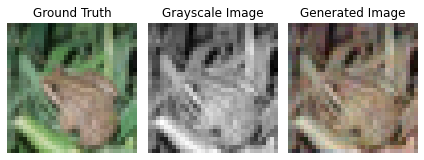

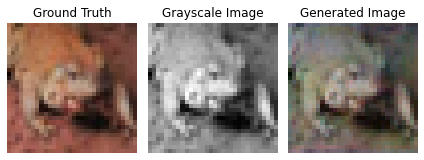

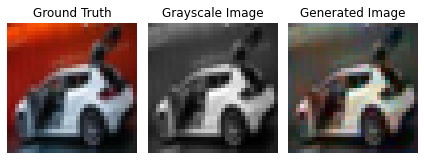

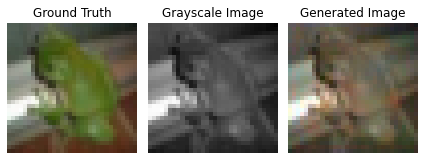

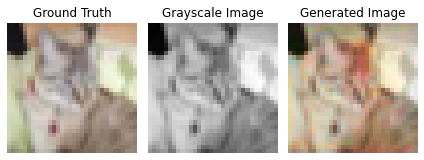

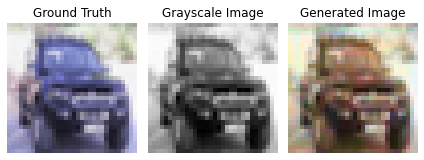

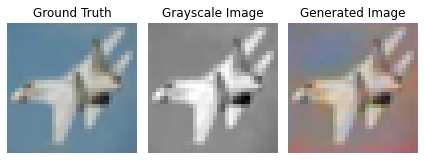

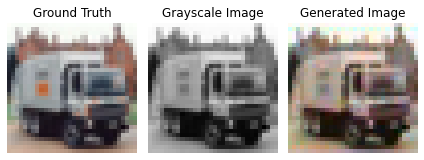

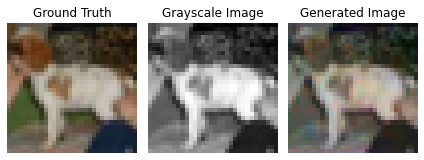

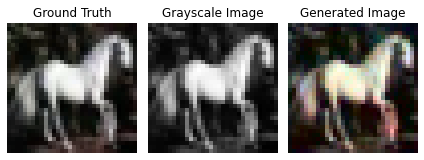

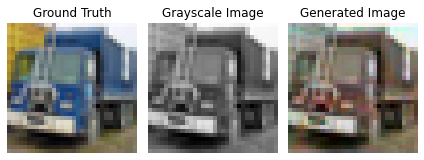

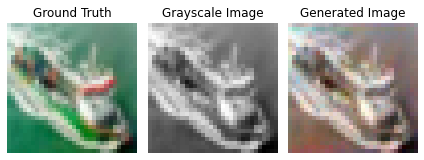

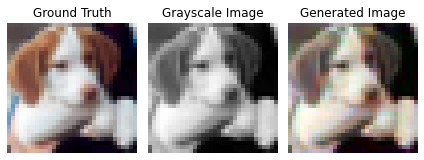

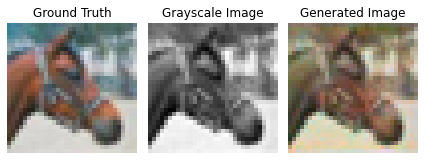

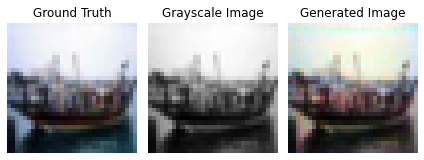

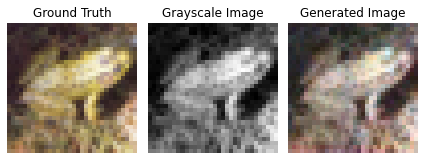

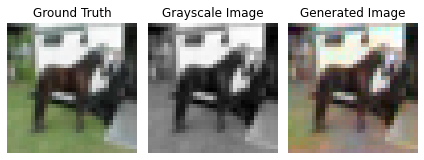

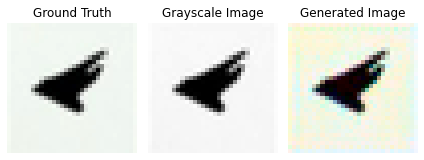

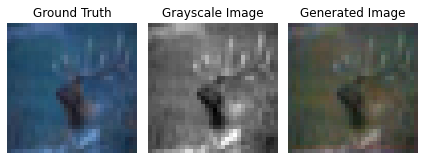

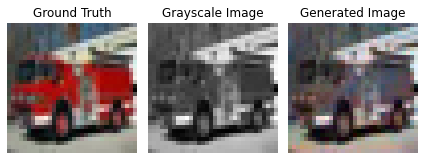

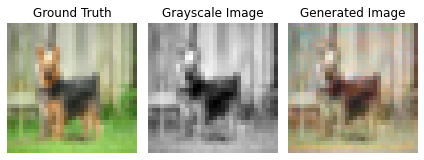

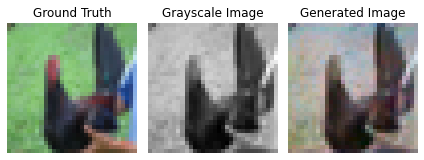

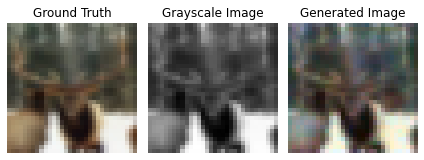

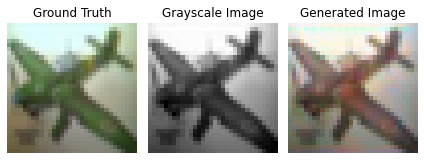

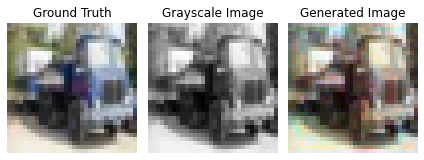

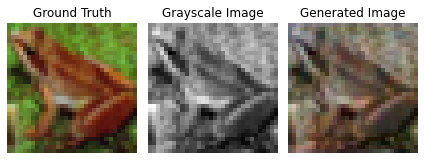

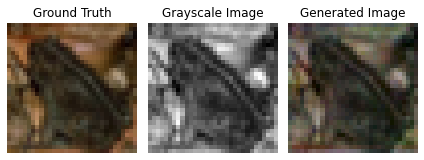

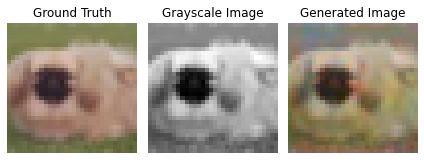

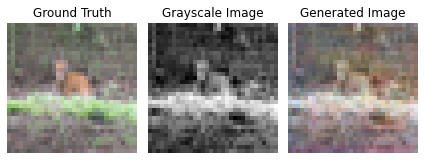

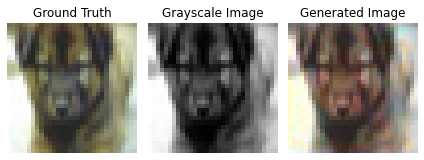

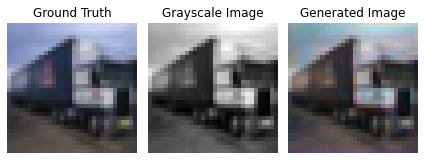

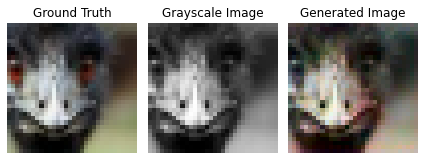

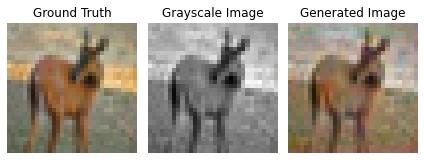

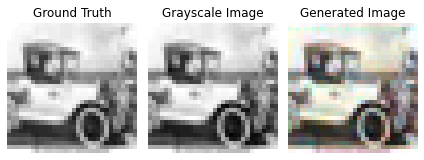

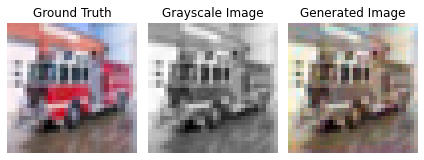

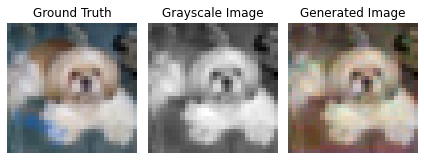

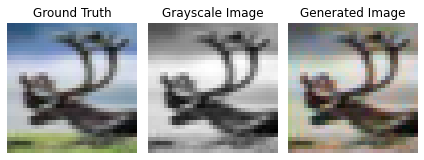

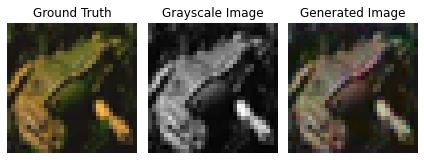

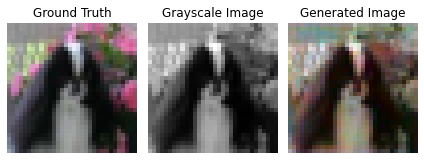

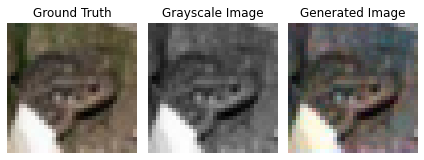

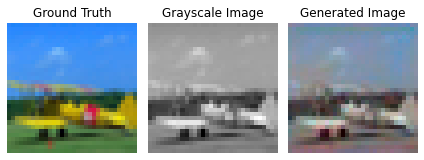

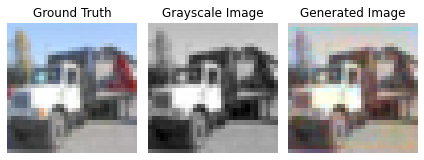

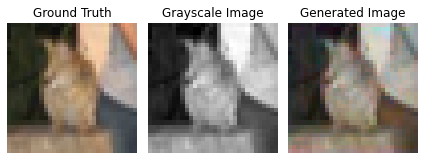

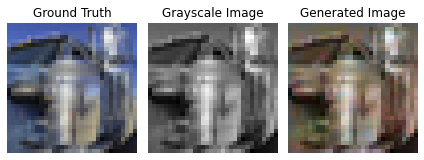

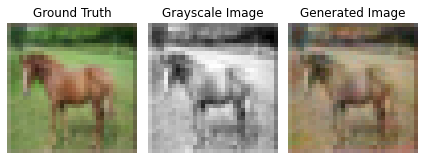

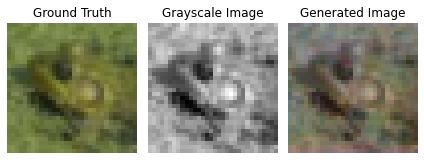

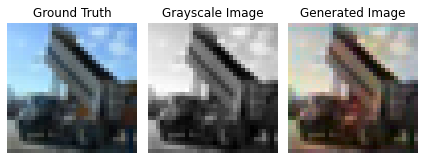

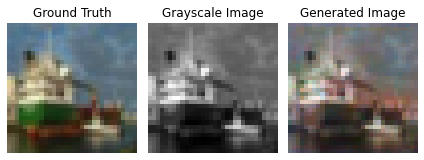

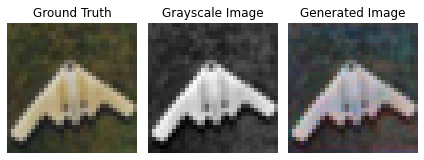

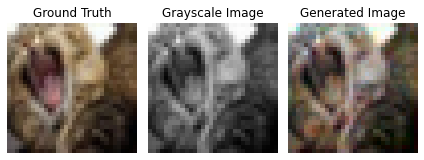

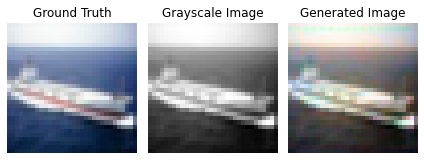

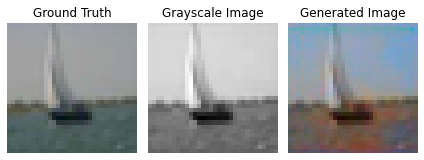

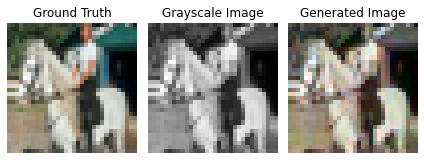

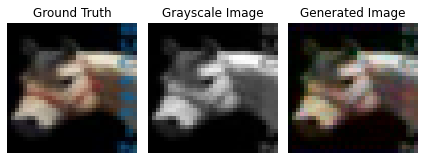

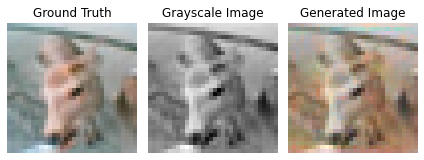

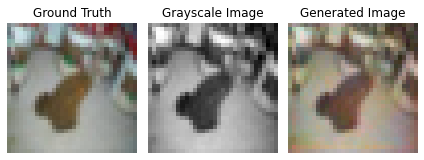

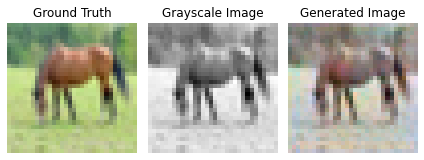

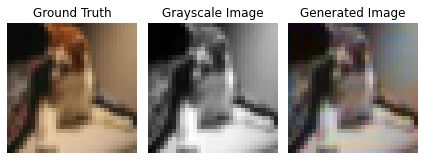

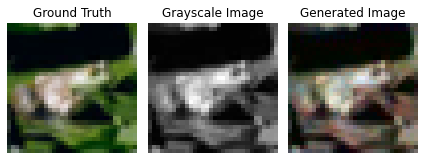

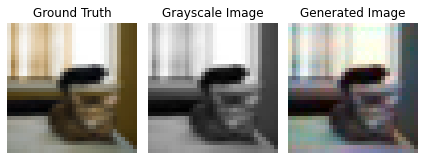

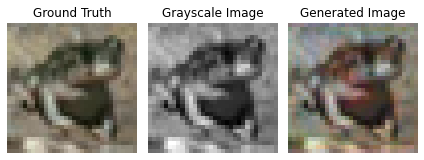

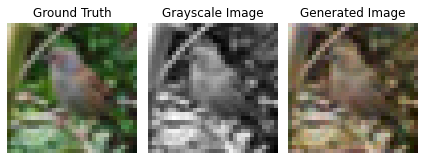

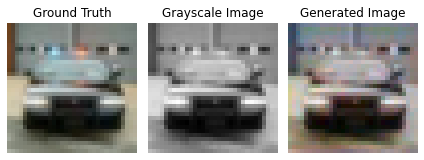

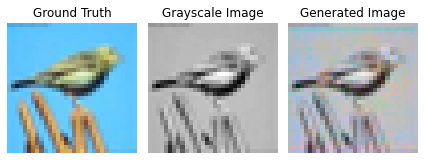

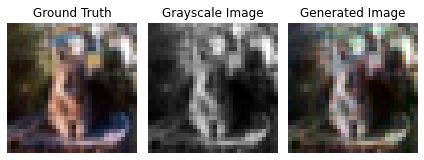

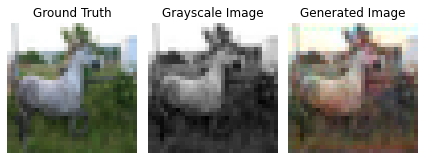

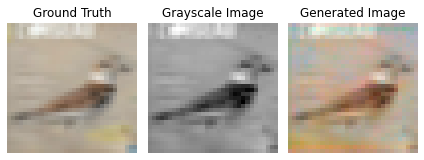

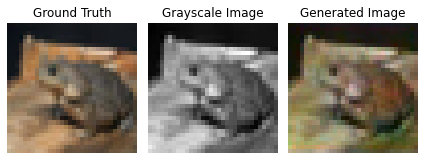

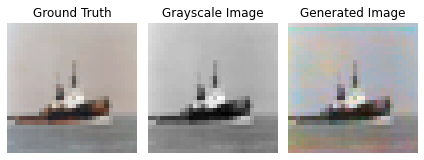

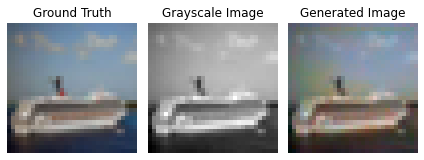

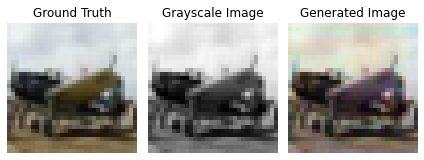

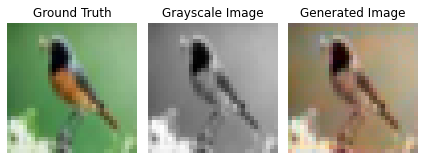

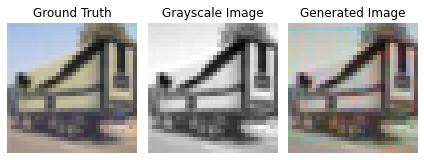

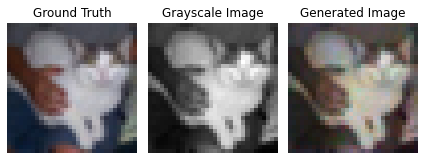

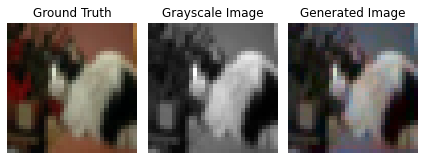

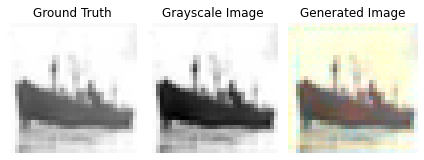

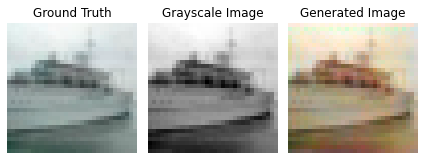

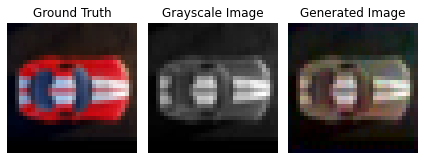

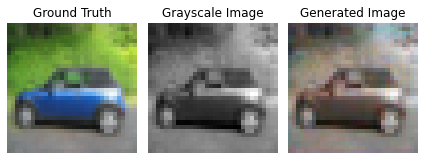

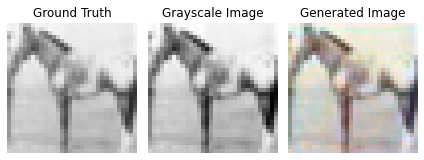

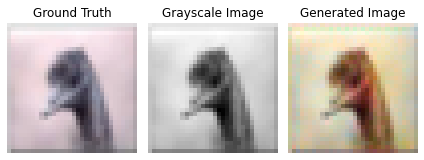

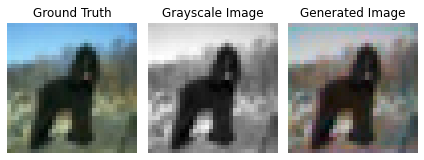

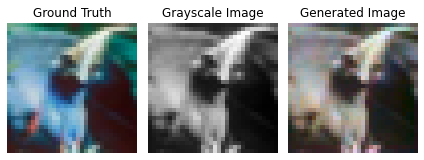

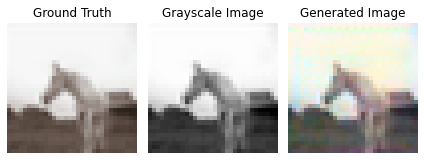

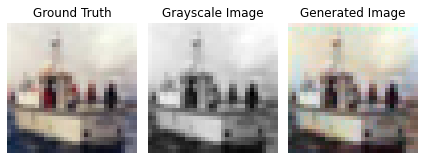

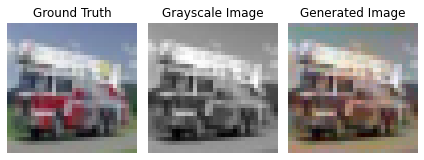

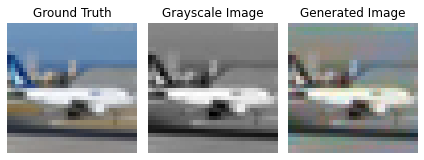

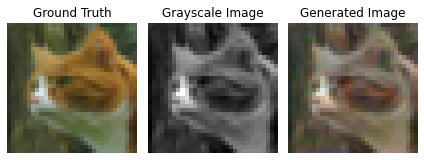

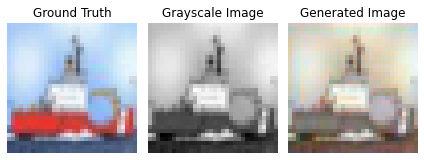

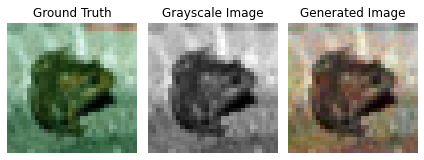

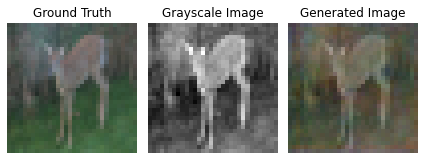

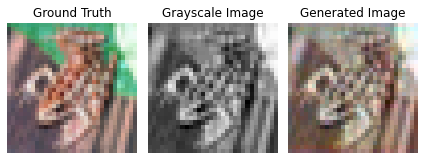

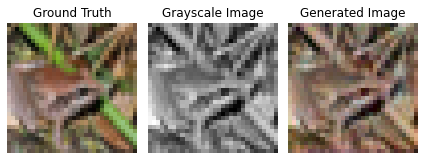

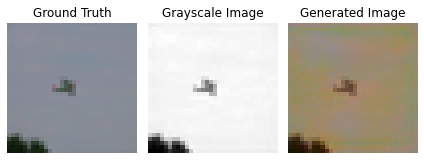

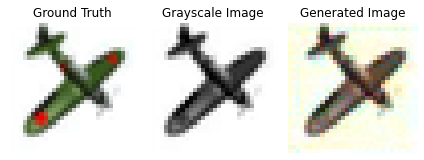

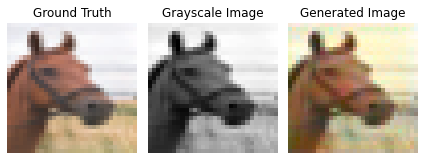

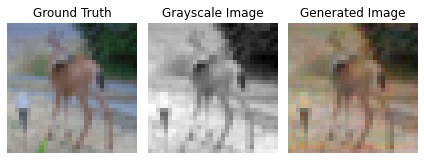

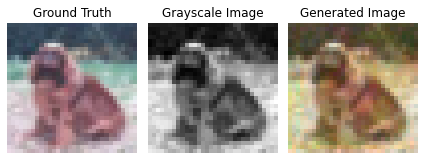

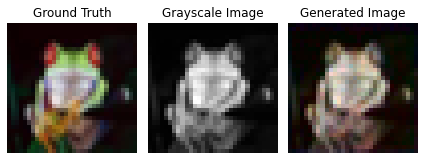

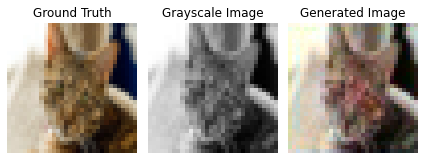

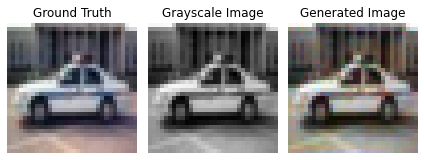

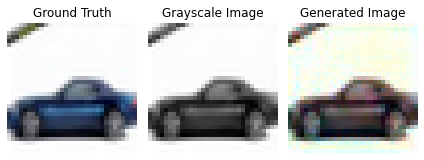

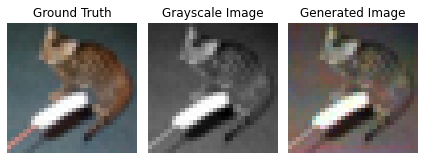

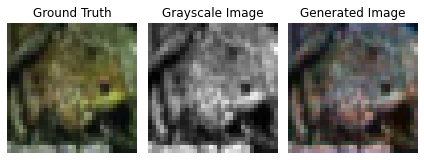

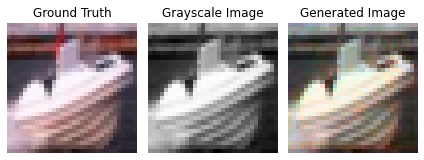

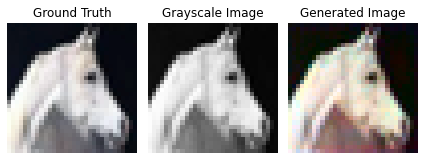

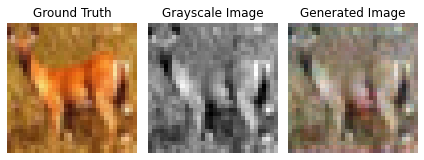

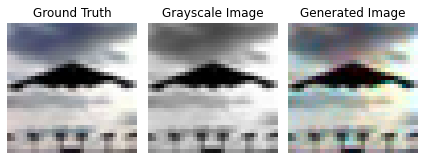

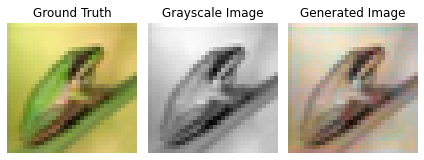

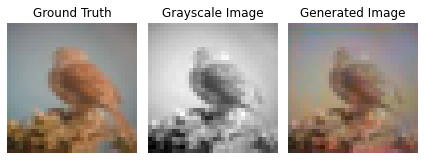

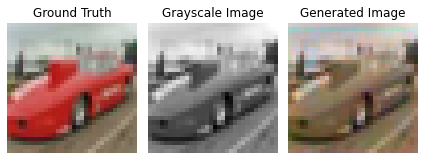

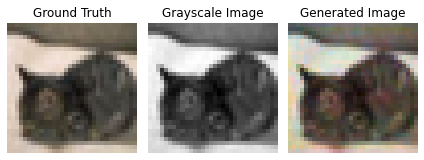

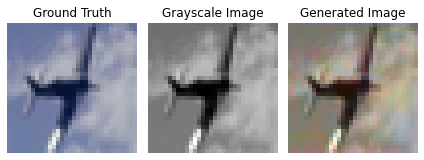

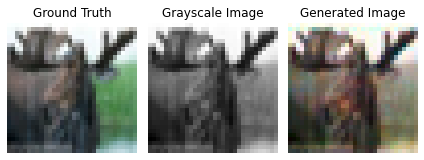

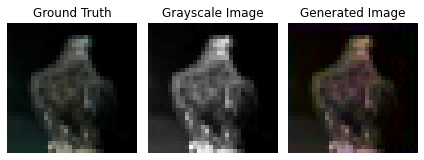

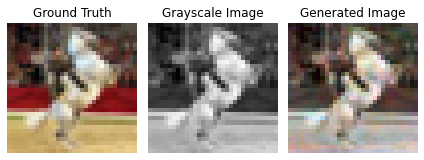

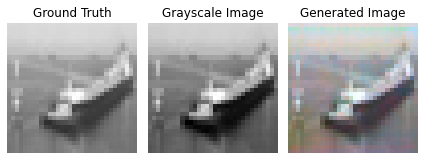

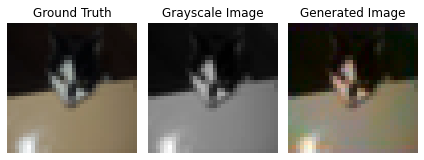

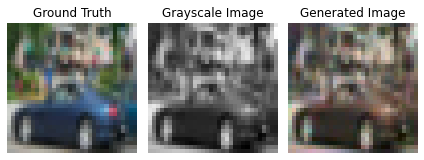

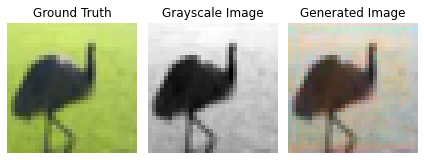

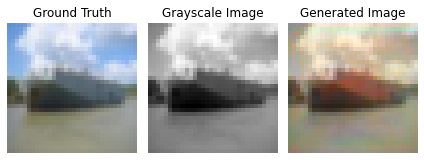

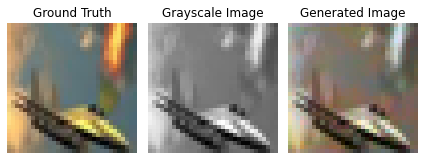

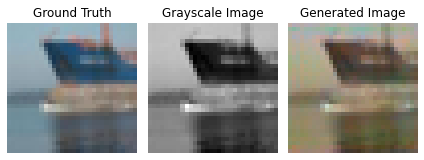

In [46]:
for i in range(127):
    visualizor(i)

# Retraining the model on 50k images

In [27]:
generator_losses = []  # List to store generator losses for each epoch
discriminator_losses = []  # List to store discriminator losses for each epoch
def train_():
    """
    Train the dataset for several epochs.
    """
    g_lambda = 100
    smooth = 0.1



    # loop over the dataset multiple times.
    for epoch in range(277):
        # the generator and discriminator losses are summed for the entire epoch.
        d_running_loss = 0.0
        g_running_loss = 0.0
        for i, data in enumerate(cielab_loader):
            lab_images = data
            # split the lab color space images into luminescence and chrominance channels.
            l_images = lab_images[:, 0, :, :]
            c_images = lab_images[:, 1:, :, :]
            # shift the source and target images into the range [-0.5, 0.5].
            mean = torch.Tensor([0.5])
            l_images = l_images - mean.expand_as(l_images)
            l_images = 2 * l_images

            c_images = c_images - mean.expand_as(c_images)
            c_images = 2 * c_images
            # allocate the images on the default gpu device.
            batch_size = l_images.shape[0]
            l_images = l_images.unsqueeze(1)
            l_images = Variable(l_images.cuda())
            c_images = Variable(c_images.cuda())
            # fake images are generated by passing them through the generator.
            fake_images = generator(l_images)
            
            

            # Train the discriminator. The loss would be the sum of the losses over
            # the source and fake images, with greyscale images as the condition.
            d_optimizer.zero_grad()
            d_loss = 0
            logits = discriminator(torch.cat([l_images, c_images], 1))
            d_real_loss = d_criterion(logits, (1 - smooth) * torch.ones(batch_size, 1).cuda())

            logits = discriminator(torch.cat([l_images, fake_images], 1))
            d_fake_loss = d_criterion(logits, torch.zeros(batch_size, 1).cuda())

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward(retain_graph=True)

            d_optimizer.step()

            # Train the generator. The loss would be the sum of the adversarial loss
            # due to the GAN and L1 distance loss between the fake and target images.
            g_optimizer.zero_grad()
            g_loss = 0
            fake_logits = discriminator(torch.cat([l_images, fake_images], 1))
            g_fake_loss = g_criterion_1(fake_logits, torch.ones(batch_size, 1).cuda())

            g_image_distance_loss = g_lambda * g_criterion_2(fake_images, c_images)

            g_loss = g_fake_loss + g_image_distance_loss
            g_loss.backward()
            g_optimizer.step()

            # print statistics on pre-defined intervals.
            d_running_loss += d_loss.item()
            g_running_loss += g_loss.item()
            
            
            
            if i % 10 == 0:
                print('[%d, %5d] d_loss: %.5f g_loss: %.5f' %
                      (epoch + 1, i + 1, d_running_loss / 10, g_running_loss / 10))
                d_running_loss = 0.0
                g_running_loss = 0.0
                
        # Append the epoch losses to the corresponding lists
        discriminator_losses.append(d_loss.item())
        generator_losses.append(g_loss.item())
        #visualize_train(data,l_images,fake_images)
        # save the generator and discriminator state after each epoch.
        torch.save(generator.state_dict(), '/kaggle/working/generator.pth')
        torch.save(discriminator.state_dict(), '/kaggle/working/discriminator.pth')


    print('Finished Training')


In [28]:
train_()

[1,     1] d_loss: 0.14899 g_loss: 1.06854
[1,    11] d_loss: 1.16826 g_loss: 9.78210
[1,    21] d_loss: 1.18058 g_loss: 9.77102
[1,    31] d_loss: 1.23334 g_loss: 9.39493
[1,    41] d_loss: 1.16427 g_loss: 9.69519
[1,    51] d_loss: 1.25466 g_loss: 9.81324
[1,    61] d_loss: 1.26065 g_loss: 9.84555
[1,    71] d_loss: 1.24669 g_loss: 9.10941
[1,    81] d_loss: 1.15582 g_loss: 9.55692
[1,    91] d_loss: 1.21225 g_loss: 9.58794
[1,   101] d_loss: 1.13754 g_loss: 9.58410
[1,   111] d_loss: 1.19557 g_loss: 9.62762
[1,   121] d_loss: 1.23295 g_loss: 9.42840
[1,   131] d_loss: 1.01755 g_loss: 9.37398
[1,   141] d_loss: 1.17819 g_loss: 9.96705
[1,   151] d_loss: 1.30264 g_loss: 9.65897
[1,   161] d_loss: 1.13439 g_loss: 9.51235
[1,   171] d_loss: 1.27351 g_loss: 9.82445
[1,   181] d_loss: 1.17274 g_loss: 9.59985
[1,   191] d_loss: 0.85831 g_loss: 8.98000
[1,   201] d_loss: 1.32881 g_loss: 9.65462
[1,   211] d_loss: 1.18455 g_loss: 9.67619
[1,   221] d_loss: 1.32935 g_loss: 10.09569
[1,   231]

KeyboardInterrupt: 

128


/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 14 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 123 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 236 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 148 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 335 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/

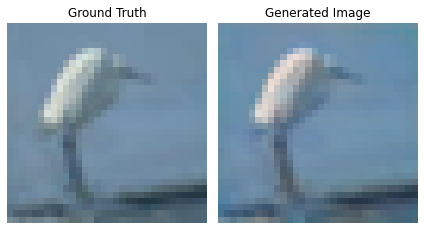

In [22]:
real_imgs = []
for data in cielab_loader:
    print(data.shape[0])
    lab_images = data
    l_images = lab_images[:, 0, :, :]
    ab_images = lab_images[:, 1:, :, :]
    
    # allocate the images on the default GPU device.
    l_images = l_images.unsqueeze(1)
    l_images = Variable(l_images.cuda())
    
    ab_images = ab_images.squeeze(1)  # Squeeze the extra dimension
    ab_images = Variable(ab_images.cuda())
    
    # Fake images are generated by passing them through the generator.
    fake_images = generator(l_images)
    
    fake_images = lab_to_rgb(l_images, fake_images)
    real_images = lab_to_rgb(l_images, ab_images)    



    rgb_image = denormer(data[0])
    
    for i in range(len(data)):
        real_imgs.append(denormer(data[i, :, :, :]))
        #print(i)

    
    # Plot the original ground truth image
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Plot the fake image generated by the generator
    plt.subplot(1, 2, 2)
    plt.imshow(fake_images[0])
    plt.title('Generated Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    break
    
    


# Results of training on 50k images for 40 epochs
These are the generated colors from train dataset.

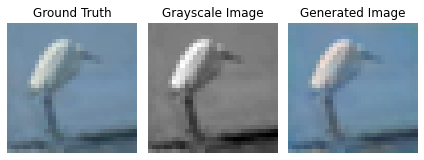

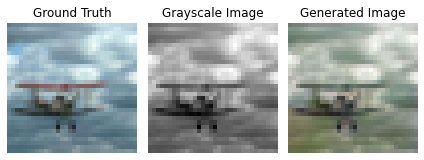

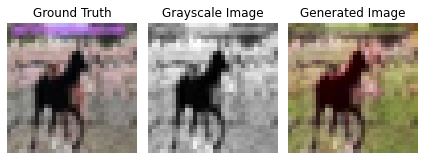

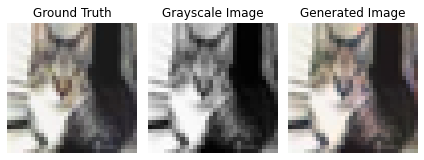

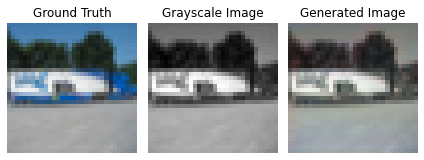

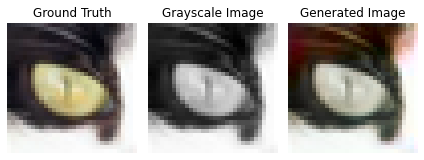

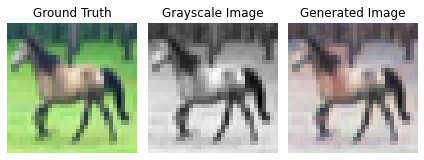

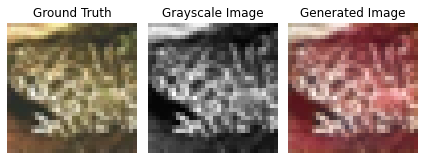

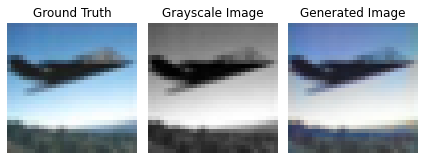

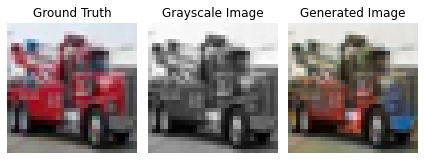

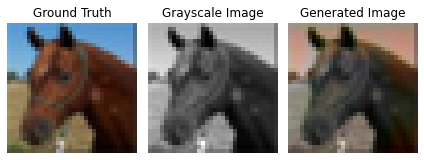

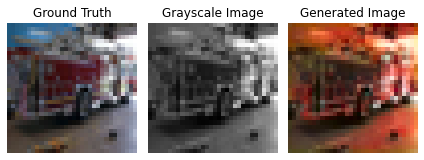

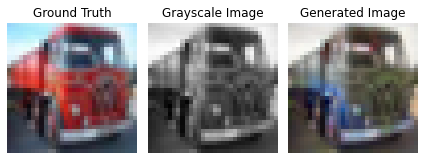

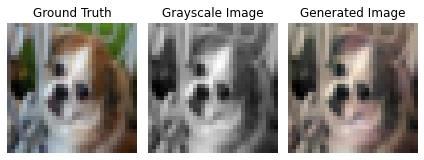

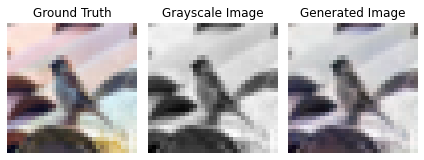

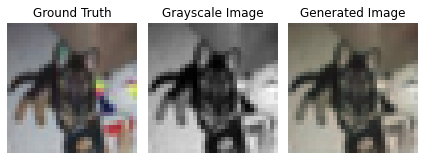

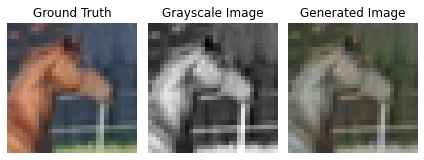

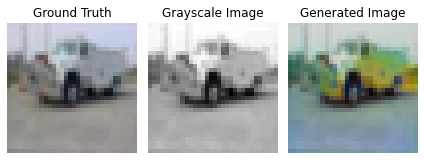

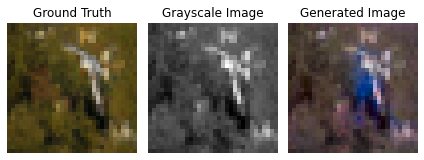

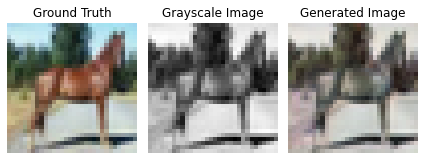

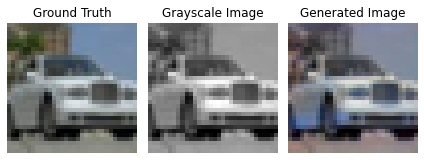

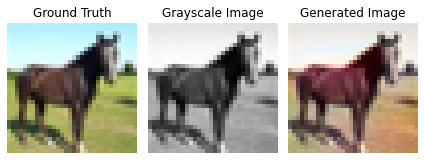

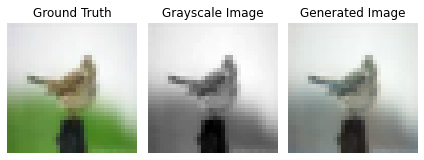

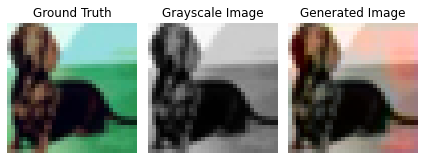

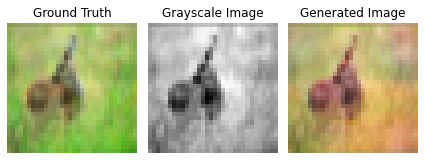

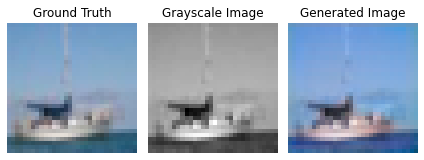

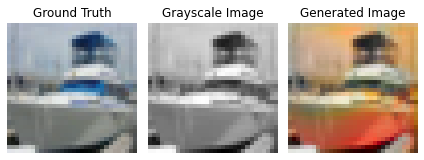

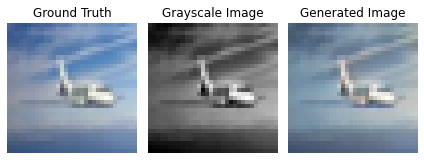

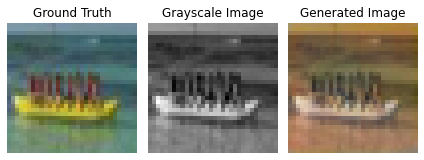

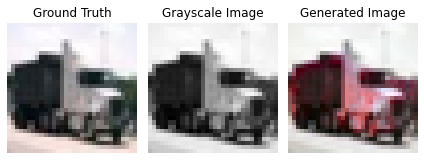

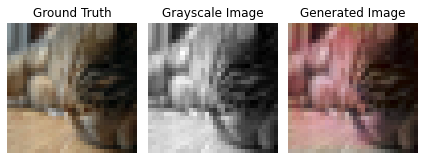

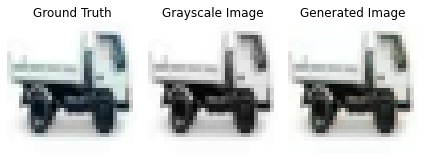

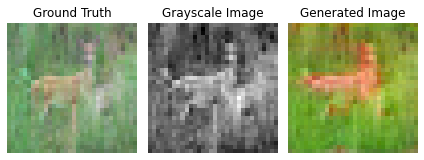

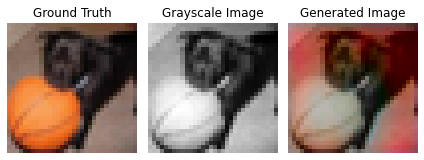

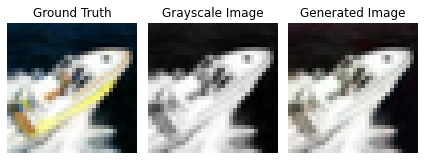

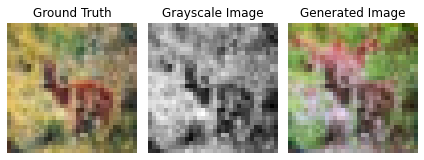

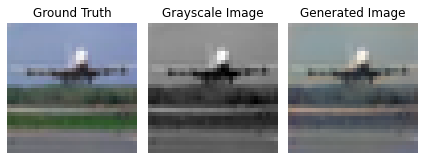

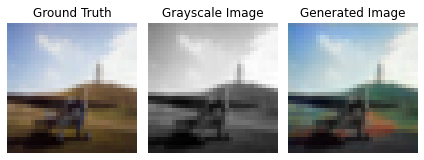

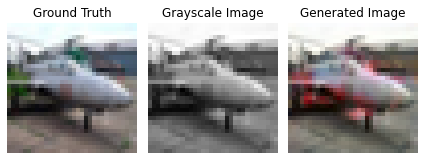

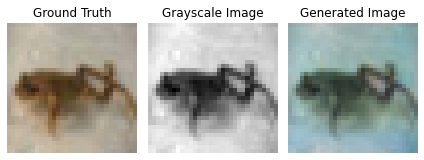

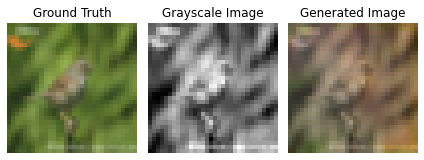

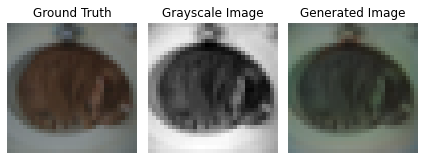

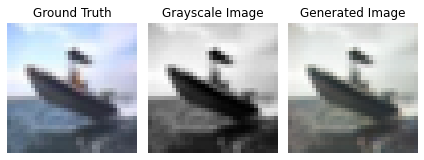

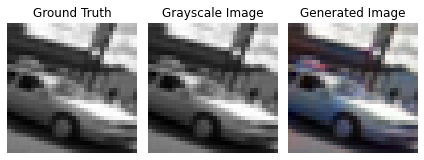

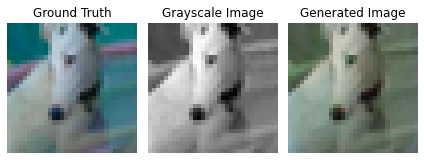

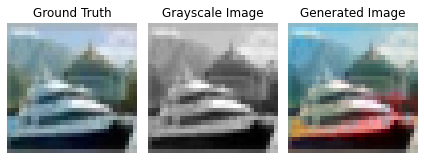

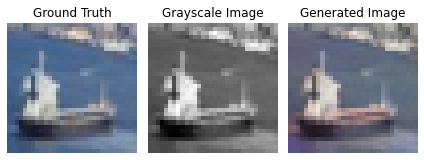

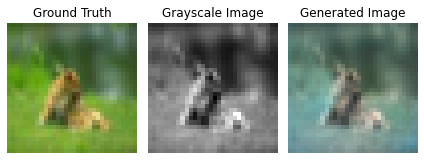

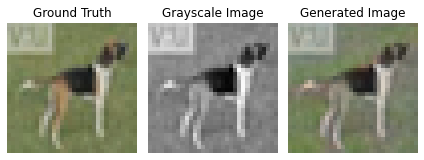

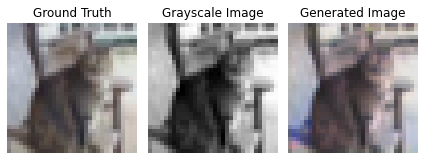

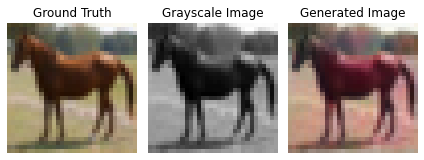

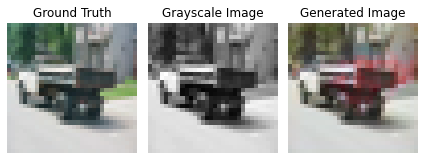

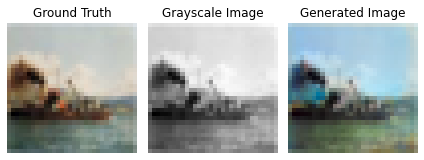

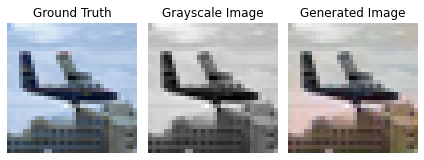

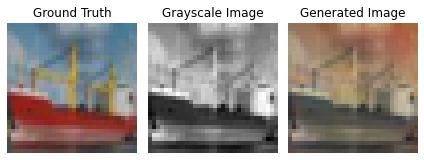

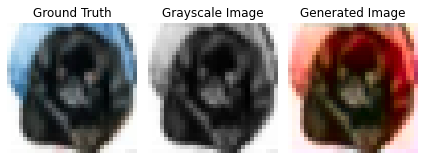

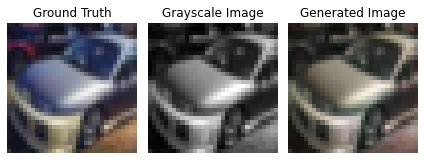

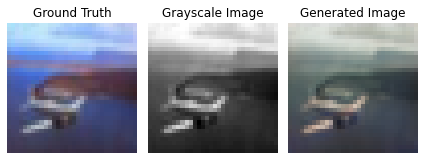

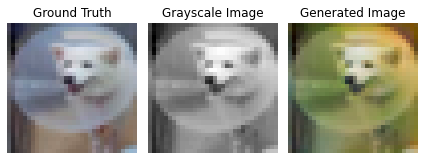

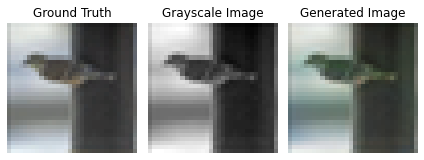

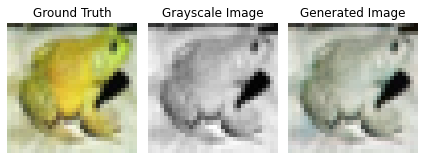

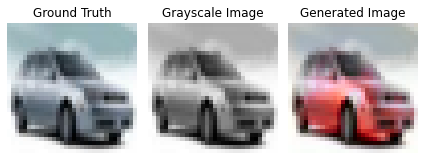

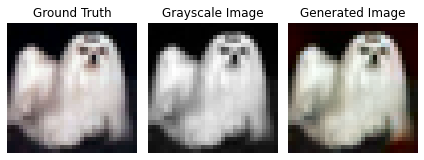

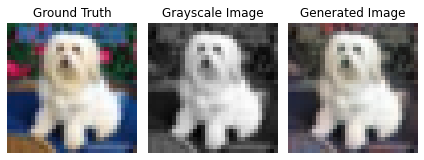

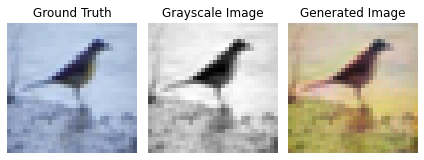

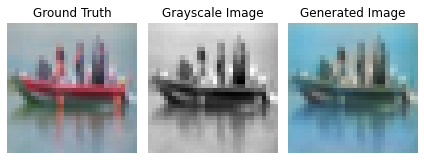

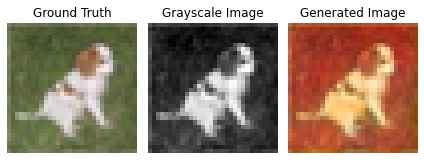

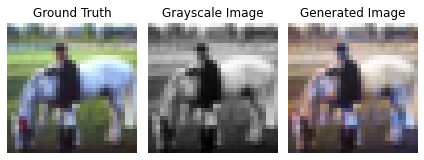

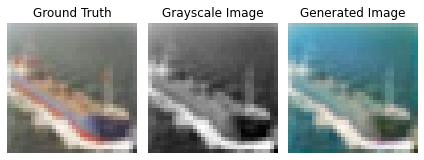

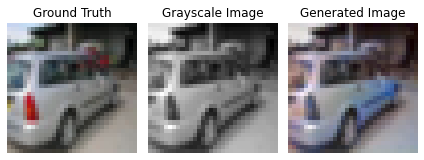

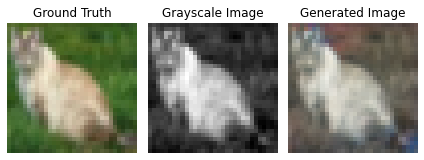

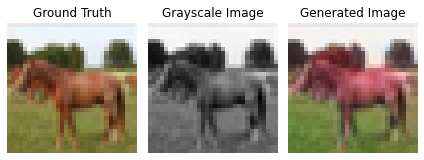

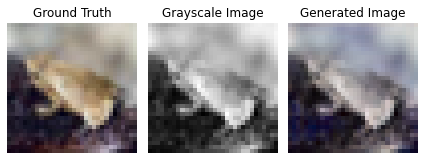

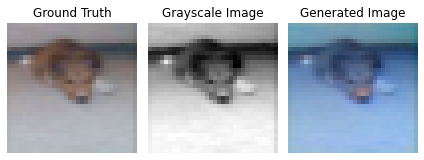

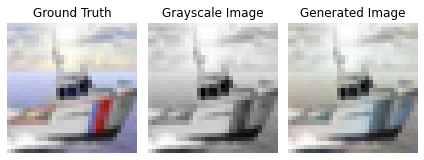

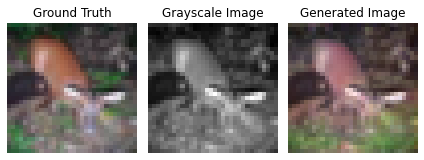

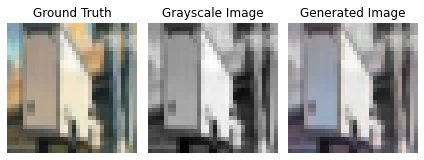

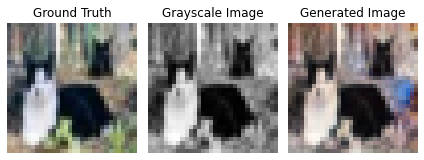

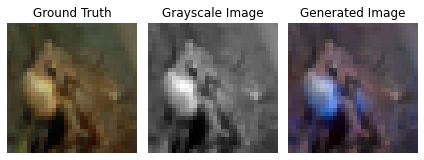

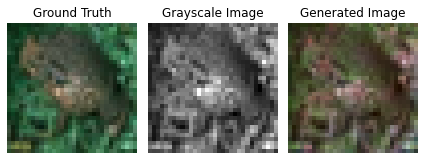

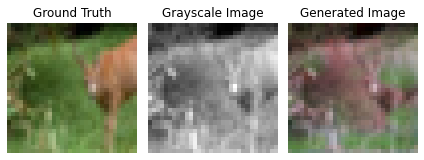

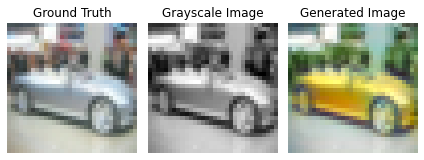

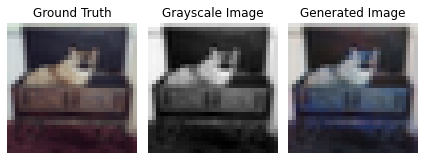

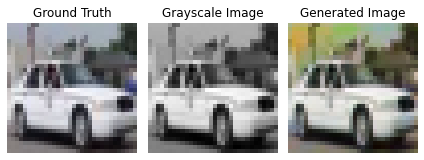

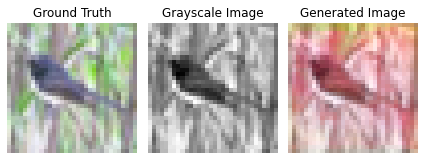

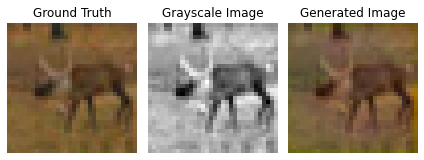

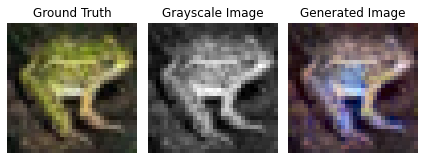

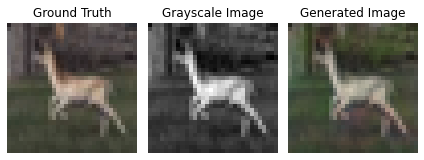

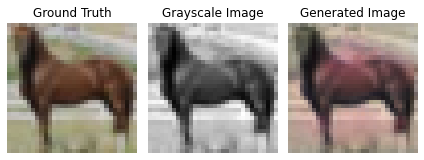

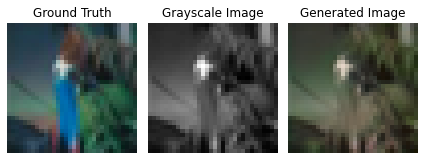

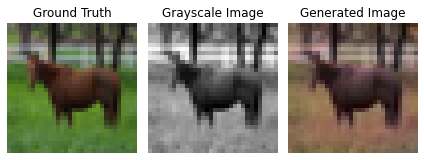

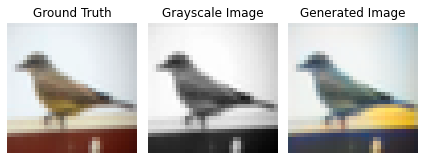

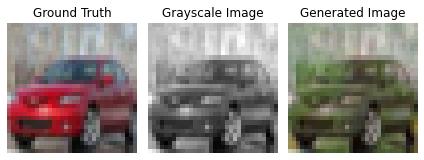

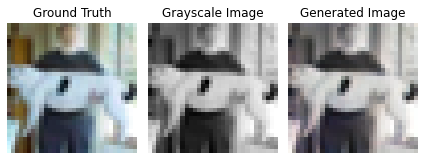

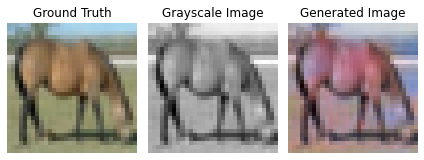

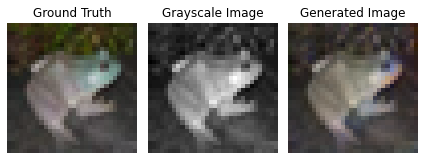

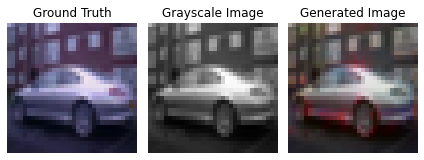

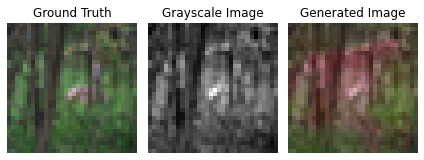

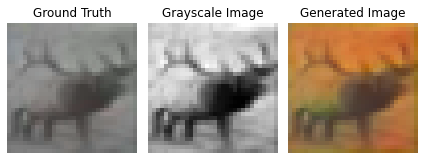

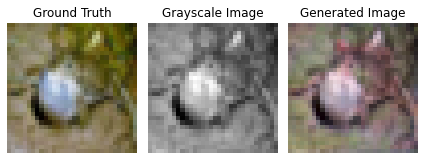

In [23]:
for i in range(100):
    visualizor(i)

## import the weights

# Testset generated images
Generator model on unseen data.

In [18]:
weights_path = '/kaggle/input/generator-weights/generator.pth'
loaded_weights = torch.load(weights_path)

# Assign the loaded weights
generator.load_state_dict(loaded_weights)


<All keys matched successfully>

128


/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 205 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 34 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 339 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 266 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 154 pixels
  return func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/skimage/_shared/

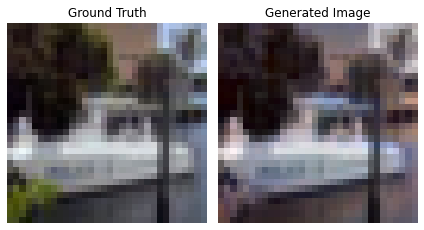

In [24]:
real_imgs = []
for data in cielab_loader_test:
    print(data.shape[0])
    lab_images = data
    l_images = lab_images[:, 0, :, :]
    ab_images = lab_images[:, 1:, :, :]
    
    # allocate the images on the default GPU device.
    l_images = l_images.unsqueeze(1)
    l_images = Variable(l_images.cuda())
    
    ab_images = ab_images.squeeze(1)  # Squeeze the extra dimension
    ab_images = Variable(ab_images.cuda())
    
    # Fake images are generated by passing them through the generator.
    fake_images = generator(l_images)
    
    fake_images = lab_to_rgb(l_images, fake_images)
    real_images = lab_to_rgb(l_images, ab_images)    



    rgb_image = denormer(data[0])
    
    for i in range(len(data)):
        real_imgs.append(denormer(data[i, :, :, :]))
        #print(i)

    
    # Plot the original ground truth image
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Plot the fake image generated by the generator
    plt.subplot(1, 2, 2)
    plt.imshow(fake_images[0])
    plt.title('Generated Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    break
    
    


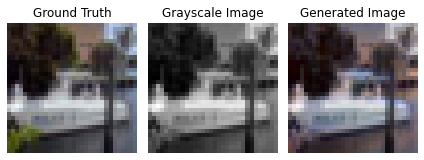

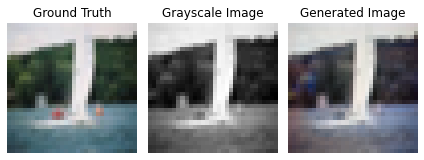

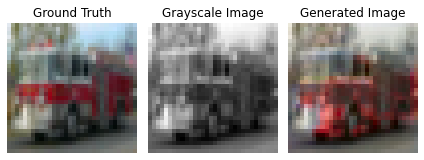

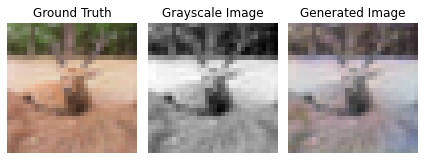

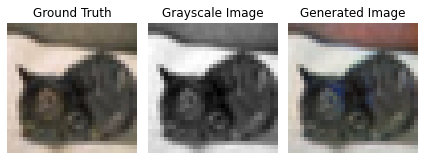

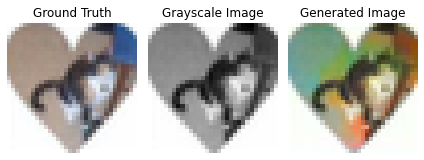

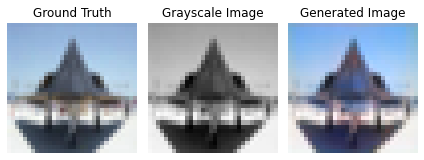

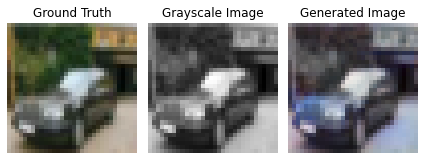

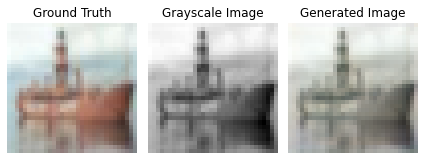

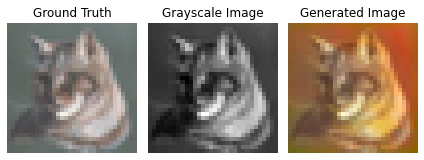

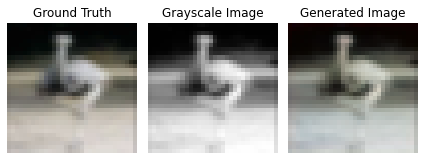

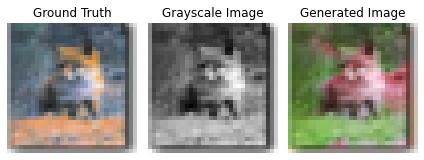

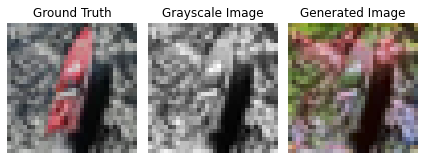

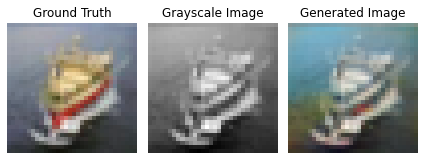

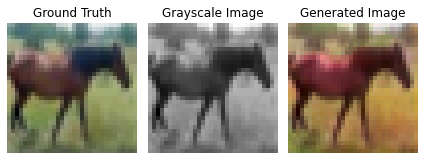

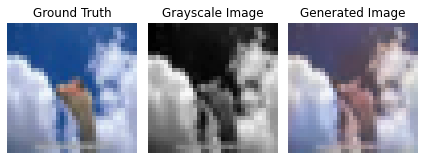

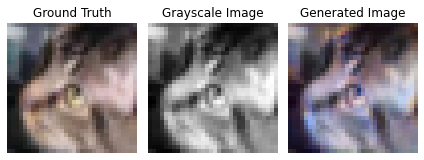

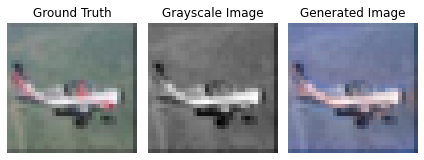

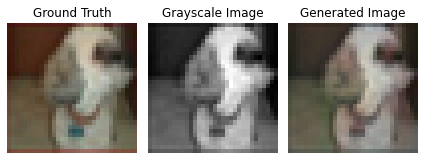

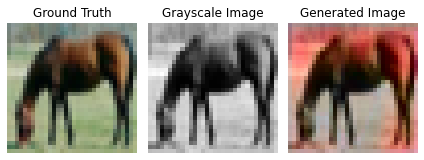

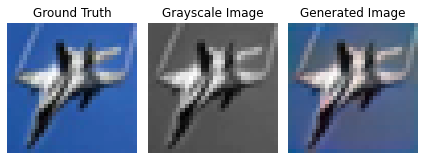

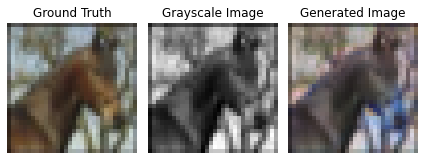

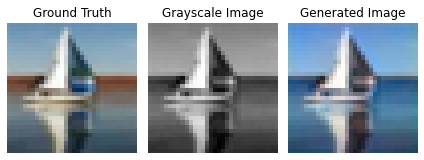

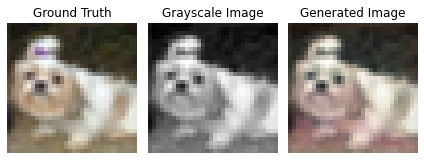

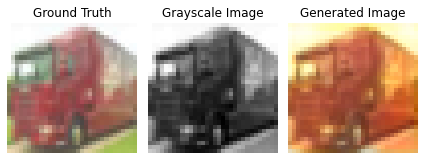

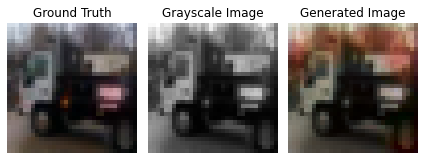

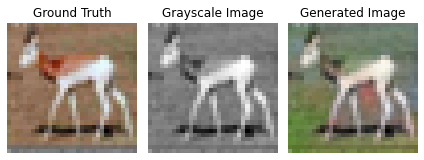

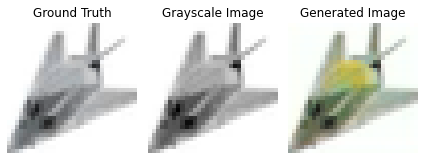

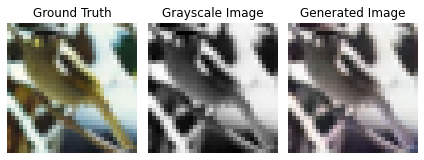

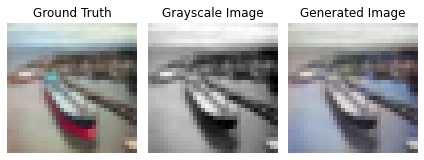

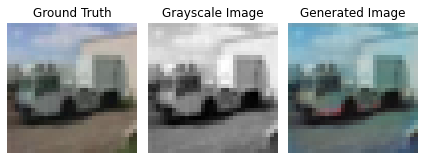

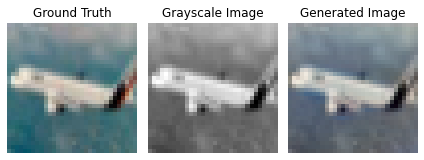

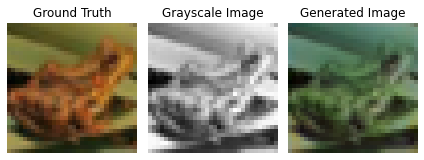

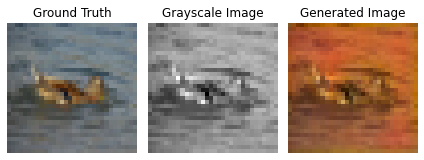

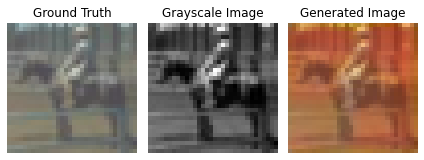

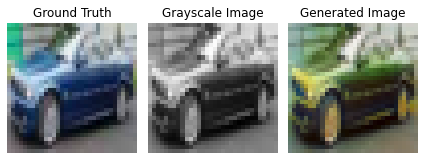

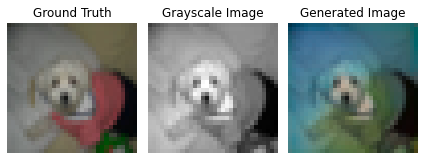

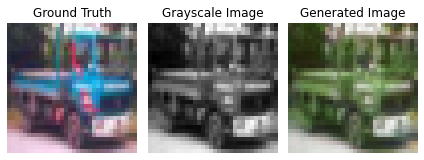

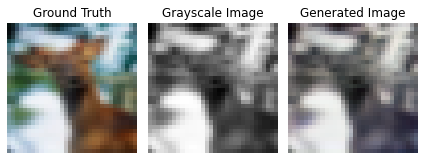

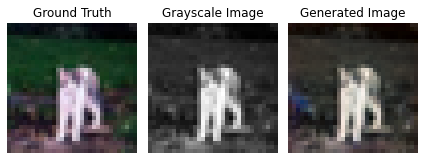

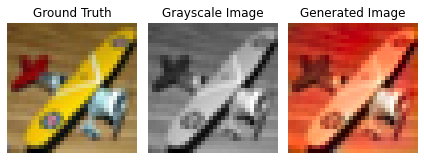

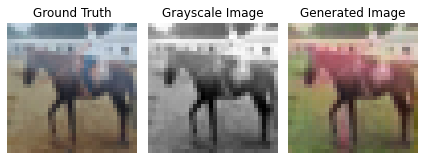

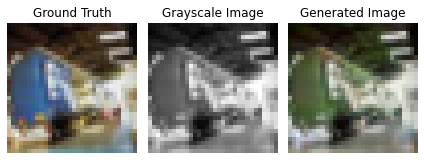

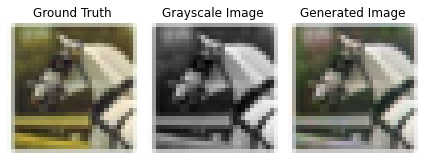

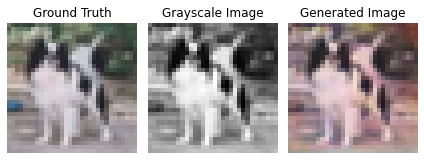

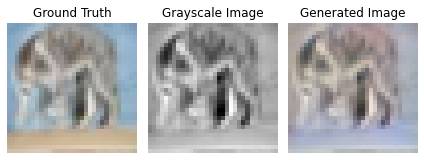

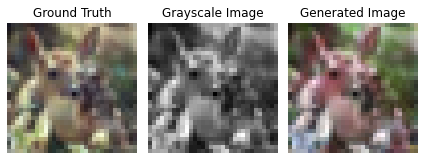

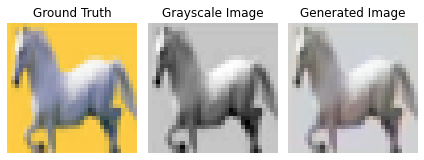

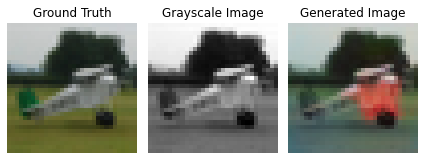

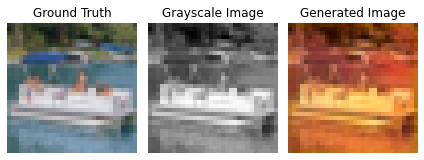

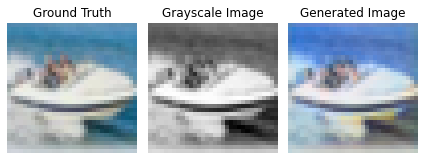

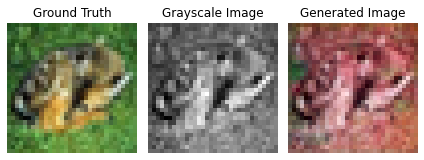

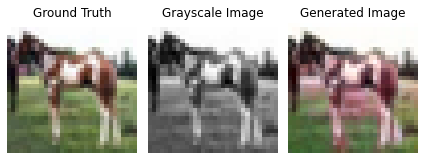

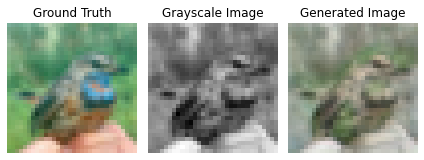

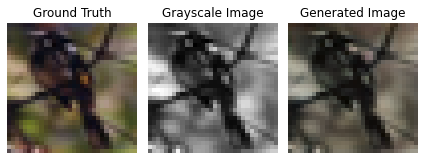

In [25]:
for i in range(55):
    visualizor(i)

# Conclusion